Gabriel Romon - Julien Chhor

**Warning**: You need a GPU with Cuda installed to run this notebook.

I. VAE for the MNIST dataset  
II. Compressed sensing  
$\quad \quad$a) Using VAEs  
$\quad \quad$b) Using basis pursuit

# I. VAE for the MNIST dataset

We use Pytorch to define a variational autoencoder with an architecture identical to that of Bora's paper.

In [8]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Loading MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Setting batch size
bs = 100
# Data Loader, used during training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [9]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # Defining the encoder architecture
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # Defining the decoder architecture
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        # Defining the encoder forward pass
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # Returning (mu, log_var)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # Returning z sample
        
    def decoder(self, z):
        # Defining the decoder forward pass
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        # Defining the global forward pass
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# Building model
# Sizes for the hidden layers are identical to those in the paper
vae = VAE(x_dim=784, h_dim1=500, h_dim2=500, z_dim=20)
if torch.cuda.is_available():
    vae.cuda()

***
**Computing the loss**:  
In the report we proved that 
$$\operatorname{KL}(q_\phi(z|x)||p(z)) = \frac 12 \sum_{i=1}^k \left(\exp \log \Sigma_{ii} - \log \Sigma_{ii} + \mu_i^2 - 1 \right)$$
and 
$$\log p_\theta(x|z) = \sum_{i=1}^n x_i \log y_i + (1-x_i) \log(1-y_i)$$
where $x$ was the input image (in vector format) and $y$ the decoded output. 

The **opposite** of $\log p_\theta(x|z)$ is thus a sum of binary cross-entropies, so if we define the reconstruction error `recon_error` directly with binary cross-entropies, the loss writes as `recon_error + KL` in the cell below.
***

In [10]:
optimizer = optim.Adam(vae.parameters())
# Defining loss as reconstruction error + KL divergence 
def loss_function(recon_x, x, mu, log_var):
    recon_error = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KL = 0.5 * torch.sum(log_var.exp() - log_var + mu.pow(2) - 1)
    return recon_error + KL

In [11]:
# Training loop
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):  # Generating batch
        data = data.cuda()
        optimizer.zero_grad()  # Telling Pytorch not to store gradients between backward passes
        
        recon_batch, mu, log_var = vae(data) # Forward pass
        loss = loss_function(recon_batch, data, mu, log_var)  # Computing loss
        
        loss.backward()  # Performing automatic differentiation w.r.t weights of the networks
        train_loss += loss.item()  # Updating loss value
        optimizer.step()  # Performing parameters update using gradients computed with .backward()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [12]:
# Computing loss on the test set
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # Adding batch loss to accumulator
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)  # Normalizing with number of samples in the test set
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [13]:
# Training the VAE for 5 epochs
for epoch in range(1, 5):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.710000
Train Epoch: 1 [10000/60000 (17%)]	Loss: 195.496523
Train Epoch: 1 [20000/60000 (33%)]	Loss: 179.331152
Train Epoch: 1 [30000/60000 (50%)]	Loss: 161.009453
Train Epoch: 1 [40000/60000 (67%)]	Loss: 137.728643
Train Epoch: 1 [50000/60000 (83%)]	Loss: 136.687959
====> Epoch: 1 Average loss: 166.1454
====> Test set loss: 130.6541
Train Epoch: 2 [0/60000 (0%)]	Loss: 124.348691
Train Epoch: 2 [10000/60000 (17%)]	Loss: 127.903125
Train Epoch: 2 [20000/60000 (33%)]	Loss: 129.126230
Train Epoch: 2 [30000/60000 (50%)]	Loss: 117.585254
Train Epoch: 2 [40000/60000 (67%)]	Loss: 124.515225
Train Epoch: 2 [50000/60000 (83%)]	Loss: 118.753086
====> Epoch: 2 Average loss: 123.6343
====> Test set loss: 116.4615
Train Epoch: 3 [0/60000 (0%)]	Loss: 115.564189
Train Epoch: 3 [10000/60000 (17%)]	Loss: 116.371377
Train Epoch: 3 [20000/60000 (33%)]	Loss: 115.007246
Train Epoch: 3 [30000/60000 (50%)]	Loss: 112.747949
Train Epoch: 3 [40000/60000 (67%)]	Loss: 113.54

***

Evaluating the output of the decoder on $64$ random $z$'s.

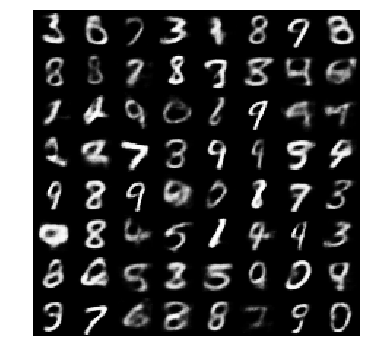

In [22]:
def show(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
with torch.no_grad():
    z = torch.randn(64, 20).cuda()  # Generating 64 random z in the representation space
    sample = vae.decoder(z).cuda()  # Evaluating the decoder on each of them
    save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')
    show(make_grid(sample.view(64, 1, 28, 28), padding=0))  # Plotting the resulting images

**Results**:
The VAE was only trained for $5$ epochs, yet it produces satisfying outputs that look like real handwritten digits.

# II. Compressed sensing

## a) Using VAEs

The function `sense()` defined below solves the problem $$\operatorname{argmin}_z \|AG(z)-y\|^2 $$
where:
* $x^*\in \mathbb R^n$ is an input image.
* $A$ is an $m\times n$ matrix with i.i.d $\mathcal N(0,\frac 1m)$ entries.
* $\eta \in \mathbb R^m$ is a random Gaussian noise with i.i.d $\mathcal N(0,\frac{0.1}{\sqrt m})$ entries.
* $y = Ax^* + \eta$ is the measurement vector.

We follow the same exact procedure as in the paper: sample $10$ random initial $z$'s and solve the problem for each initialization using Adam optimizer with learning rate $0.01$. Gradients are computed automatically using Pytorch's `autograd` library. We return the $z$ that yields lowest measurement error at the end.

Adding `requires_grad_(False)` on all the variables except `z` ensures that only `z` is being optimized on.

In [65]:
def sense(A, y, regularization=False):
    z_best = torch.randn(1, 20).cuda()
    z_best.requires_grad_(False)
    for _ in range(10):  # Performing 10 random restarts, i.e. repeat for 10 initial random z's
        z = torch.randn(1, 20).cuda()
        z.requires_grad_(True)
        
        optimizer = optim.Adam([z], lr = 0.01)  # Using same optimizer configuration as in the paper
                                                # Only parameter for optimization is z
        for _ in range(1000):  # Performing 1000 gradient steps, as in the paper
            AG_z = torch.mm(A,vae.decoder(z).view(-1,1).cuda())  # Computing AG(z)
            if regularization:
                loss = torch.pow(torch.norm(AG_z - y), 2) + 0.1*torch.pow(torch.norm(z),2)
            else:
                loss = torch.pow(torch.norm(AG_z - y), 2)
            optimizer.zero_grad()
            loss.backward()  # Using automatic differentiation on the loss
            optimizer.step()
        sample = vae.decoder(z).cuda()
        with torch.no_grad():
            if loss < torch.pow(torch.norm(torch.mm(A,vae.decoder(z_best).view(-1,1).cuda())-y),2):
                z_best = z  # Keeping z with smallest measurement error
    return z_best

The function `generate()` defined below takes as input an image vector `x_star`, generates `A` and the measurement `y`, and reconstructs the image using `sense()`.

In [75]:
m = 100
n = 784

def generate(m, n, x_star, regularization=False):
    normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0/m]))
    A = normal.sample((m,n)).squeeze().cuda()
    A.requires_grad_(False)
    
    normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([0.1/np.sqrt(m)]))
    noise = normal.sample((m,)).cuda()
    noise.requires_grad_(False)
    
    y = torch.mm(A,x_star) + noise
    y.cuda()
    y.requires_grad_(False)
    
    z = sense(A, y, regularization)
    return vae.decoder(z).view(28, 28).detach().cpu().numpy()

The code below generates reconstructions for every digit from $0$ to $9$.

In [104]:
labels = []
images = []
for (image, label) in test_dataset:
    if label not in labels:
        labels.append(label)
        images.append(image)
outputs_noreg = [generate(m, n, x_star.view(28*28,1).cuda(), False) for x_star in images]
outputs_reg = [generate(m, n, x_star.view(28*28,1).cuda(), True) for x_star in images]

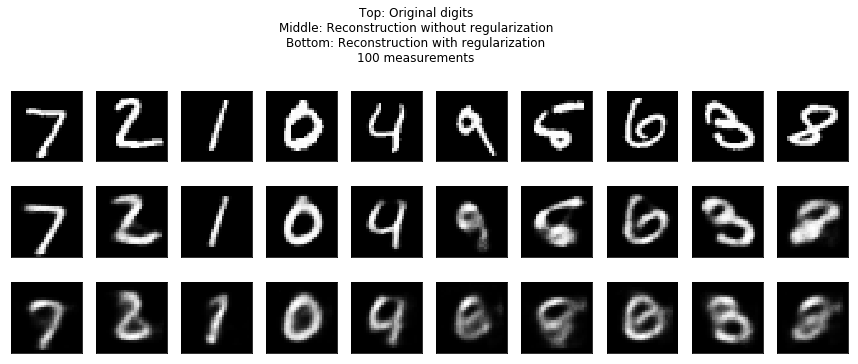

In [118]:
fig, ax = plt.subplots(3, 10, figsize=(15,5))
for j in range(10):
    ax[0,j].imshow(images[j].view(28,28).cpu().numpy(), cmap ='gray')
    ax[1,j].imshow(outputs_noreg[j], cmap ='gray')
    ax[2,j].imshow(outputs_reg[j], cmap ='gray')
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
    ax[2,j].set_xticks([])
    ax[2,j].set_yticks([])
fig.suptitle('''Top: Original digits
Middle: Reconstruction without regularization
Bottom: Reconstruction with regularization
100 measurements''', y = 1.1)
plt.show()

## Results
The method provided in the paper works as intended. The results shown above were obtained with $100$ measurements (out of the 784 of the original image).  

For the $z$ found by gradient descent, $G(z)$ is indeed a faithful reconstruction of the digit. 

By comparing the second and the third row, one notices that adding regularization (with strength 0.1 as done in the paper) **severely degrades** the quality of the reconstructions, which become quite blurry.

Below we show results with $25$ measurements.

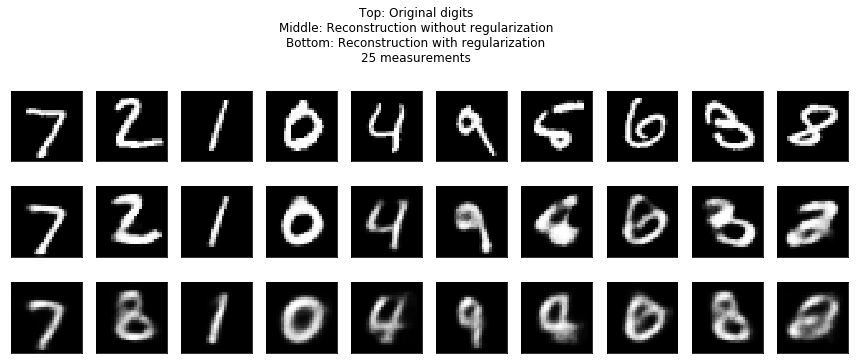

In [209]:
m=25

labels = []
images = []
for (image, label) in test_dataset:
    if label not in labels:
        labels.append(label)
        images.append(image)
outputs_noreg = [generate(m, n, x_star.view(28*28,1).cuda(), False) for x_star in images]
outputs_reg = [generate(m, n, x_star.view(28*28,1).cuda(), True) for x_star in images]

fig, ax = plt.subplots(3, 10, figsize=(15,5))
for j in range(10):
    ax[0,j].imshow(images[j].view(28,28).cpu().numpy(), cmap ='gray')
    ax[1,j].imshow(outputs_noreg[j], cmap ='gray')
    ax[2,j].imshow(outputs_reg[j], cmap ='gray')
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
    ax[2,j].set_xticks([])
    ax[2,j].set_yticks([])
fig.suptitle('''Top: Original digits
Middle: Reconstruction without regularization
Bottom: Reconstruction with regularization
25 measurements''', y = 1.1)
plt.show()

With only $25$ measurements the reconstructions have not lost much in quality, which is quite surprising.

## b) Using basis pursuit

The function `basis_pursuit()` defined below solves the problem $$\operatorname{argmin_x} \|x\|_1 \quad s.t. \; \; Ax=y$$

The function `generate_lasso()` defined below takes as input an image vector `x_star`, generates `A` and the measurement `y`, and reconstructs the image using `basis_pursuit()`.

In [203]:
m = 100
n = 784

def basis_pursuit(n, A, y):
    P, q = np.array(A.cpu()), np.array(y.cpu()).astype(np.double).flatten()
    x = cvx.Variable(n)
    obj = cvx.Minimize(cvx.norm(x,1))
    const = [P * x == q]
    prob = cvx.Problem(obj,const)
    result = prob.solve()
    return x.value

def generate_lasso(m, n, x_star):
    normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0/m]))
    A = normal.sample((m,n)).squeeze().cuda()
    
    normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([0.1/np.sqrt(m)]))
    noise = normal.sample((m,)).cuda()

    y = torch.mm(A,x_star) + noise
    y.cuda()
    
    return basis_pursuit(n, A, y)

In [204]:
outputs_lasso = [generate_lasso(m, n, x_star.view(28*28,1).cuda()) for x_star in images]

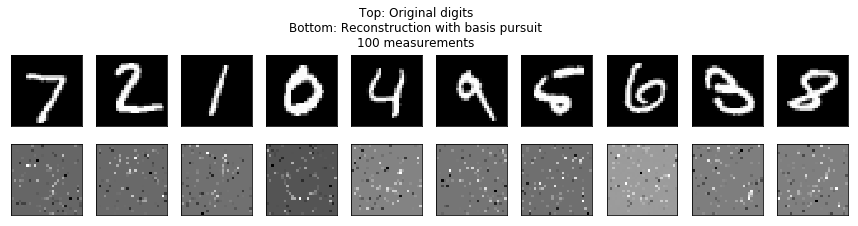

In [206]:
fig, ax = plt.subplots(2, 10, figsize=(15,3))
for j in range(10):
    ax[0,j].imshow(images[j].view(28,28).cpu().numpy(), cmap ='gray')
    ax[1,j].imshow(outputs_lasso[j].reshape(28,28), cmap ='gray')
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
fig.suptitle('''Top: Original digits
Bottom: Reconstruction with basis pursuit
100 measurements''', y = 1.1)
plt.show()

In [207]:
m=300
outputs_lasso = [generate_lasso(m, n, x_star.view(28*28,1).cuda()) for x_star in images]

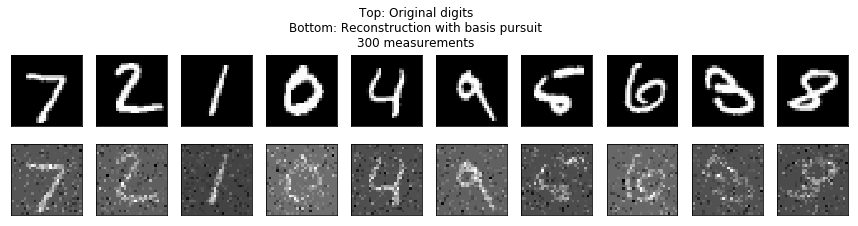

In [208]:
fig, ax = plt.subplots(2, 10, figsize=(15,3))
for j in range(10):
    ax[0,j].imshow(images[j].view(28,28).cpu().numpy(), cmap ='gray')
    ax[1,j].imshow(outputs_lasso[j].reshape(28,28), cmap ='gray')
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])
fig.suptitle('''Top: Original digits
Bottom: Reconstruction with basis pursuit
300 measurements''', y = 1.1)
plt.show()

## Results:

We show results of basis pursuit with $100$ and $300$ measurements. For $m=100$ the reconstructions are useless, and for $m=300$ they are arguable decent.

Basis pursuit compares very poorly against the VAE. **However**, one should not forget that the VAE was trained beforehand on a large relevant dataset, whereas basis pursuit works with **no prior knowledge of the data**.